In [1]:
# import tensorflow.compat.v1 as tf
# from tensorflow.compat.v1 import keras
from os import listdir
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread, imsave, imshow
import numpy as np
import pandas as pd
import math
from scipy.signal import convolve2d
from skimage import img_as_ubyte, img_as_float
from skimage.transform import resize
# from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
# from keras import Sequential
# from keras import layers
import copy
from skimage.color import rgb2gray
from sklearn.metrics import mean_squared_error as MSE
import gc
import os.path
from skimage.metrics import structural_similarity as SSIM
from skimage.metrics import peak_signal_noise_ratio as PSNR
from scipy import interpolate
import pickle
gc.enable()

from lib import *

In [25]:
import copy
# from cv2 import rotate
import gc
import matplotlib.pyplot as plt
import math
import numpy as np
import os
from PIL import Image
from skimage.transform import radon
import scipy.signal as ss
from scipy import ndimage, interpolate
import time

tmp = []
counter = 0

def make_directory(dirname):
    if (not os.path.exists(dirname)):
        os.mkdir(dirname)
    return 

def FixImage(image):
    '''
    Returns image with values in [0, 1] segment
    for normal output with possible negative elements
    '''
    min_value = image.min()
    max_value = image.max()
    if min_value < 0:
        image -= min_value
    return image / (max_value - min_value)

def images_out(class_elem):
    '''
    Relatively normal output 
    of _cur_image and _init_image 
    in element of FunctionalMinimisation class
    '''
    plt.figure(figsize=(35,35))
    plt.subplot(1,2,1)
    plt.imshow(FixImage(class_elem._cur_image), cmap='gray')

    plt.subplot(1,2,2)
    plt.imshow(FixImage(class_elem._init_image), cmap='gray')

DEBUG = True
temp_dir = 'temp/'

def save_img(class_elem, p='my_stuff.png', p_b='blurred.png', dir_to_save=temp_dir):
    plt.imsave(os.path.join(dir_to_save, p),   class_elem._cur_image, cmap='gray')
    plt.imsave(os.path.join(dir_to_save, p_b), class_elem._init_image, cmap='gray')

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.299 * r + 0.5870 * g + 0.1140 * b
    return gray

def blend_images(orig, four, alpha = 0.8, colH = 10, w=1):
    orig_img = Image.open(orig).convert('RGBA')
    fourier_img = Image.open(four).convert('RGBA')
        
    orig_img = orig_img.resize(((fourier_img.size[0], fourier_img.size[1])), Image.BICUBIC)
    
    img = fourier_img
    A = img.getchannel('A')

    # Convert to HSV and save the V (Lightness) channel
    V = img.convert('RGB').convert('HSV').getchannel('V')

    # Synthesize new Hue and Saturation channels using values from colour picker
    colpickerH, colpickerS = colH, 255
    newH=Image.new('L',img.size,(colpickerH))
    newS=Image.new('L',img.size,(colpickerS))

    # Recombine original V channel plus 2 synthetic ones to a 3 channel HSV image
    HSV = Image.merge('HSV', (newH, newS, V))

    # Add original Alpha layer back in
    R,G,B = HSV.convert('RGB').split()
    RGBA = Image.merge('RGBA',(R,G,B,A))
    
    new_img = Image.blend(orig_img, RGBA, alpha)
    return new_img

def calculate_log(picture,threshold=0.5):
    log = np.log(np.abs(np.fft.fft2(Cepstrum.hamming(picture))))
    fourier_abs = np.abs(log)
    return fourier_abs

def wiener_filter(img, kernel, K=1):
    if np.shape(kernel)[0] == 0:
        return img
    kernel /= np.sum(kernel)
    dummy = np.copy(img)
    dummy = np.fft.fft2(dummy)
    kernel = np.fft.fft2(kernel, s = img.shape)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    dummy = dummy * kernel
    dummy = np.abs(np.fft.ifft2(dummy))
    return dummy

def get_blur_len(img, angle, weight, w=2):
    # img[img == img.max()] = 0
    # img[img < 0.7 * img.max()] = 0
    # cur_img = FixImage(img)
    # rotated_img = ndimage.rotate(cur_img, -angle * 180/math.pi)
    # blur_len = 0
    # max_val = rotated_img[rotated_img.shape[0] // 2 - w : rotated_img.shape[0] // 2 + w].max(axis=0)
    # wid = rotated_img.shape[1] // 2
    # for i in range(wid):
    #     if (max_val[i] > 0.05):
    #         blur_len = wid - i
    #         break
    rotated_img = ndimage.rotate(img, -angle * 180/math.pi)
    rotated_img[rotated_img < 4/255 * rotated_img.max()] = 0
    max_val = rotated_img[rotated_img.shape[0] // 2 - w : rotated_img.shape[0] // 2 + w].max(axis=0)
    idxs = range(len(max_val))
    r = max_val
    # r = radon(rotated_img, theta=[90], circle=False)
    # r[r > 0.6 * r.max()] = 0
    r *= 1./max(r)
    for i in range(len(r)):
        if (r[i] > 0.03):
            blur_len = len(r) // 2 - 1 - i 
#             if (blur_len > 2 * img.shape[0] // 5):
#                 blur_len = 0
            break
    global counter
    plt.imsave('temp/' + str(counter) + 'rotated_ceps.png', rotated_img)
    counter += 1
    if (DEBUG):
        h = img.shape[0]
        q = h // 2 - 1
        k = -math.tan(angle)
        b = (1 - k) * q
        new_blur_len = blur_len * 15
        l = []
        if abs(abs(angle * 180/math.pi) - 90) > 10:
            for old_x in range(q - new_blur_len, q + new_blur_len):
                old_y = round(k * old_x+b)
                old_y = int((old_y if old_y >= 0 else 0) if old_y <= h-1 else h-1)
                if (old_y <= 1 or old_y >= h-2 or old_x <= 1 or old_x >= h-2):
                    continue
                for i in range(-w, w+1):
                    for j in range(-w, w+1):
                        x = old_x
                        y = old_y
                        y += i
                        y = (y if y >= 0 else 0) if y <= h-1 else h-1
                        x += j
                        x = (x if x >= 0 else 0) if x <= h-1 else h-1
                        if (y, x) not in l:
                            l.append((y, x))
        else:
            for y in range(q - new_blur_len, q + new_blur_len):
                for i in range(-w, w+1):
                    if (y, q + i) not in l:
                        l.append((y, q + i))
        p = np.zeros((h, h))
        for t in l:
            try:
                p[t] = weight
            except Exception as e:
                print(e)
        return (int(abs(blur_len)), p)
    else:
        return int(abs(blur_len))

def find_best_line(template_picture, dif=180):
    h = template_picture.shape[0]
    q = h // 2 - 1
    theta = np.linspace(0., 180, dif, endpoint=False)
    sinogram = radon(template_picture, theta=theta, circle=True)
    max_values = sinogram.max(axis=0)
    if DEBUG:
        tmp.append(sinogram)
    return (max(max_values), theta[np.argmax(max_values)] * math.pi/180 - math.pi/2)

def make_ker(ker_len, ker_angle):
#     h = ker_len * 2
    h = ker_len
    ker_len = ker_len // 2
    ker_angle = math.pi/180 * ker_angle
    ker = np.zeros((h, h), dtype='float')
    
    k = -math.tan(ker_angle)
    b = (1 - k) * ker_len
    if abs(abs(ker_angle * 180/math.pi) - 90) > 10:
        for x in range(h):
            y = round(k * x + b)
            y = int((y if y >= 0 else 0) if y <= h-1 else h-1)
            if (y == 0 or y == h - 1):
                continue
            ker[y, x] = 1
    else:
        for y in range(h):
            ker[y, ker_len] = 1 
    if ker.sum() > 0:
        ret_value = ker/ker.sum()
        return ret_value
    else:
        return []
    # if np.isnan(np.sum(ret_value)):
    #     return []
    # else:
    #     return ret_value

class Cepstrum:
    def __init__(self, picture, batch_size=256, step=0.5, dir_to_save=temp_dir):
        gc.enable()
        self.batch_size = batch_size
        self.step = step
        self.dir_to_save = dir_to_save
        make_directory(dir_to_save)
        self.x_batches = int(picture.shape[1] // (batch_size * step) - 1)
        self.y_batches = int(picture.shape[0] // (batch_size * step) - 1)
        self.picture = copy.deepcopy(picture)
        self.squared_image = [0] * self.x_batches * self.y_batches
        self.MainProcess()
        if (DEBUG):
            plt.imsave(os.path.join(self.dir_to_save, 'orig_img.png'), self.picture, cmap='gray')

    def get_square(self):
        pixel_step = int(self.batch_size * self.step)
        for y in range(self.y_batches):
            for x in range(self.x_batches):
                square = self.picture[y * pixel_step : y * pixel_step + self.batch_size,
                                   x * pixel_step : x * pixel_step + self.batch_size]
                self.squared_image[y * self.x_batches + x] = square
                orig_ceps = Cepstrum.calculate_cepstrum(square)
                self.orig_cepstrums.append(self.swap_quarters(orig_ceps))
                yield self.swap_quarters(Cepstrum.get_k_bit_plane(orig_ceps))

    def ft_array(self):
        # CALCULATE CEPSTRUMS
        
        t = time.time()
            
        self.count_ft()
        if (DEBUG):
            print("Counted cepstrums: ", time.time() - t)
        self.count_angles()
        if (DEBUG):
            print("Counted angles: ", time.time() - t)
        self.count_lengths()
        if (DEBUG):
            print("Counted lengths: ", time.time() - t)
        self.make_kernels()
        if (DEBUG):
            print("Counted kernels: ", time.time() - t)
        
        self.weight = self.weight.reshape((self.y_batches, self.x_batches))

        self.angle = self.angle.reshape((self.y_batches, self.x_batches))
        self.blur_len = self.blur_len.reshape((self.y_batches, self.x_batches))
        if (np.max(self.blur_len) == 0) :
            self.angle_value = 0
            print("Unable to calculate blur lengths")
            return
        self.blur_len_value, self.angle_value = self.get_common_ker_len_angle()
        self.kernel_image = make_ker(self.blur_len_value, self.angle_value)
        self.squared_image = np.reshape(self.squared_image, (self.y_batches, self.x_batches, self.batch_size, self.batch_size))
        if (DEBUG):
            self.save_vector_field()
        print("Total time: ", time.time() - t)
        
    def MainProcess(self):
        self.ft_array()
        try:
            temp2 =[ 0 ] * self.y_squares
            for y in range(self.y_squares):
                temp2[y] = np.hstack(self.restored_image[y, :, :, :])
            self.restored_image_full = np.vstack(temp2)
        except AttributeError as error:
            return
            
    def hamming(picture):
        hm_len = picture.shape[0]
        bw2d = np.outer(ss.hamming(hm_len), np.ones(hm_len))
        bw2d = bw2d * bw2d.T
        return picture * bw2d
    
    def calculate_cepstrum(picture, threshold=0.5):
        log = np.log(1 + np.abs(np.fft.fft2(Cepstrum.hamming(picture))))
        fourier_abs = np.abs(np.fft.ifft2(log))
        # fourier_abs[fourier_abs >= threshold * fourier_abs.max()] = 0
        # fourier_abs[fourier_abs >= threshold * fourier_abs.max()] = 0
        
        return fourier_abs
    
    def get_k_bit_plane(img, k_list = [4, 5], width=8):
        lst = []
        img = (FixImage(img) * 255).astype(int)
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                lst.append(np.binary_repr(img[i][j], width=width)) # width = no. of bits
        out_img = np.zeros_like(img)
        for k in k_list:
            assert(k <= width)
            out_img += (np.array([int(i[k]) for i in lst],dtype = np.uint8) * 2**(width-k)).reshape(img.shape[0],img.shape[1])
        return out_img

    def swap_quarters(self, picture):
        out_pict = copy.deepcopy(picture)
        batch_size = picture.shape[0]
        temp_pict = copy.deepcopy(out_pict[: batch_size//2, : batch_size//2])
        out_pict[: batch_size//2, : batch_size//2] = out_pict[batch_size//2 :, batch_size//2 :]
        out_pict[batch_size//2 :, batch_size//2 :] = temp_pict
        temp_pict = copy.deepcopy(out_pict[: batch_size//2, batch_size//2 :])
        out_pict[: batch_size//2, batch_size//2 :] = out_pict[batch_size//2 :, : batch_size//2]
        out_pict[batch_size//2 :, : batch_size//2] = temp_pict[:]
        return out_pict
    
    def get_common_ker_len_angle(self):
        w = self.weight / self.weight.sum()
        return (int(np.ceil(np.multiply(w, self.blur_len).sum())), np.median(self.angle))

    def count_ft(self):
        self.orig_cepstrums = list()
        self.cepstrum_picture = np.array(list(self.get_square()))
        self.conc_cepstrum_picture = self.cepstrum_picture.reshape((self.y_batches, self.x_batches, self.batch_size, self.batch_size))
        temp  = [ 0 ] * self.y_batches
        for y in range(self.y_batches):
            temp[y] = np.hstack(self.conc_cepstrum_picture[y, :, :, :])
        self.conc_cepstrum_picture = np.vstack(temp)
        plt.imsave(os.path.join(self.dir_to_save, 'big_img.png'), self.conc_cepstrum_picture, cmap='gray')
    
    def count_angles(self):
        self.weight = np.ndarray((self.y_batches * self.x_batches), dtype='float')
        self.angle = np.ndarray((self.y_batches * self.x_batches), dtype='float')
        if (DEBUG):
            self.lines_img = np.zeros_like(self.cepstrum_picture, dtype=float)
        for idx, q in enumerate(self.cepstrum_picture):
            self.weight[idx], self.angle[idx] = find_best_line(q)
        self.weight /= self.weight.max()
                
    def count_lengths(self):
        self.blur_len = np.ndarray((self.y_batches * self.x_batches), dtype='int')
        for idx, q in enumerate(self.orig_cepstrums):
            if (DEBUG): 
                self.blur_len[idx], self.lines_img[idx] = get_blur_len(q, self.angle[idx], self.weight[idx])
                self.conc_lines_img = self.lines_img.reshape((self.y_batches, self.x_batches, self.batch_size, self.batch_size))
                temp  = [ 0 ] * self.y_batches
                for y in range(self.y_batches):
                    temp[y] = np.hstack(self.conc_lines_img[y, :, :, :])
                self.conc_lines_img = np.vstack(temp)
                plt.imsave(os.path.join(self.dir_to_save, 'lines_img.png'), self.conc_lines_img, cmap='gray')
            else:
                self.blur_len[idx] = get_blur_len(q, self.angle[idx], self.weight[idx])
            
    def make_kernels(self):
        self.kernels = [0] * self.y_batches * self.x_batches
        for idx, q in enumerate(self.cepstrum_picture):
            self.kernels[idx] = (self.blur_len[idx], self.angle[idx])
            
    def save_vector_field(self):
        s = self.angle.shape
        print(s)
        x = np.zeros(s[0] * s[1])
        y = np.zeros(s[0] * s[1])
        u = np.zeros(s[0] * s[1])
        v = np.zeros(s[0] * s[1])

        for idx0 in range(s[0]):
            for idx1 in range(s[1]):
                cur_idx = idx0 * s[0] + idx1
                try:
                    y[cur_idx] = s[0] - 1 - idx0
                    x[cur_idx] = idx1
                    u[cur_idx] = self.blur_len[idx0][idx1] * np.cos(self.angle[idx0][idx1])
                    v[cur_idx] = self.blur_len[idx0][idx1] * np.sin(self.angle[idx0][idx1])
                except Exception as e:
                    print

        k = 10
        yy = np.linspace(0, s[0] - 1, k)
        xx = np.linspace(0, s[1] - 1, k)
        xx, yy = np.meshgrid(xx, yy)

        points = np.transpose(np.vstack((x, y)))
        u_interp = interpolate.griddata(points, u, (xx, yy), method='cubic')
        v_interp = interpolate.griddata(points, v, (xx, yy), method='cubic')

        plt.figure(figsize=(s[1]*2,s[0]*2))
        plt.quiver(xx, yy, u_interp, v_interp)
        plt.savefig(os.path.join(self.dir_to_save, 'vector_fielld.png'))
    
    def restore_function(self, img, kernel):
        pass



Counted cepstrums:  1.4655234813690186
Counted angles:  7.878455638885498
Counted lengths:  8.996078491210938
Counted kernels:  8.99707841873169
(4, 3)
Total time:  9.10705304145813


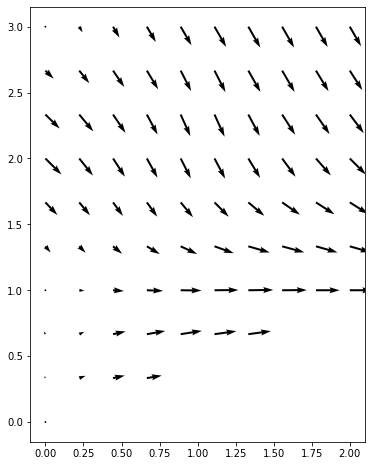

In [26]:
img = 'C:\dev\images\mb.jpg'
img = plt.imread(img)
tmp = []
counter = 0
c = Cepstrum(rgb2gray(img))

In [35]:
def blend_images(orig, four, alpha = 0.8, colH = 10, w=1):
    orig_img = Image.open(orig).convert('RGBA')
    fourier_img = Image.open(four).convert('RGBA')
        
    orig_img = orig_img.resize(((fourier_img.size[0], fourier_img.size[1])), Image.BICUBIC)
    
    img = fourier_img
    A = img.getchannel('A')

    # Convert to HSV and save the V (Lightness) channel
    V = img.convert('RGB').convert('HSV').getchannel('V')

    # Synthesize new Hue and Saturation channels using values from colour picker
    colpickerH, colpickerS = 128, 128
    newH=Image.new('L',img.size,(colpickerH))
    newS=Image.new('L',img.size,(colpickerS))

    # Recombine original V channel plus 2 synthetic ones to a 3 channel HSV image
    HSV = Image.merge('HSV', (newH, newS, V))

    # Add original Alpha layer back in
    R,G,B = HSV.convert('RGB').split()
    RGBA = Image.merge('RGBA',(R,G,B,A))
    
    new_img = Image.blend(orig_img, RGBA, alpha)
    return new_img

In [44]:
i = blend_images("C:\dev\DeblurGANv2\\temp\\orig_img.png", "C:\dev\DeblurGANv2\\temp\\lines_img.png")

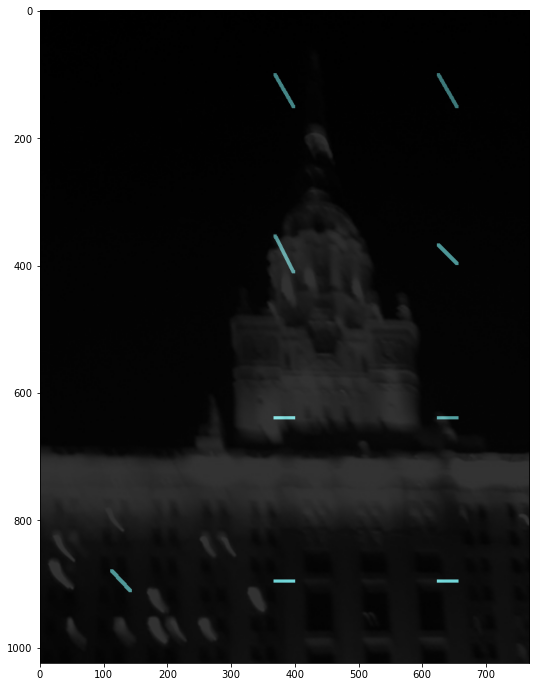

In [46]:
plt.figure(figsize=(12, 12))
plt.imshow(i)
# plt.imsave('temp/blended.png', i)